#### Imports 

In [19]:
# import libraries
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from datetime import timedelta
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 7
%matplotlib inline

##### Load Dataset

In [ ]:
df = pd.read_csv('covid_19_data.csv')

#### Data Cleaning 

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df['Province/State'].unique()

In [6]:
df["ObservationDate"]=pd.to_datetime(df["ObservationDate"])

In [7]:
bydate=df.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
bydate.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,653.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1438.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


#### EDA 

In [8]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(df["Country/Region"].unique()))
print("Total number of Confirmed Cases: ",bydate["Confirmed"].iloc[-1])
print("Total number of Recovered Cases: ",bydate["Recovered"].iloc[-1])
print("Total number of Deaths Cases: ",bydate["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(bydate["Confirmed"].iloc[-1]-bydate["Recovered"].iloc[-1]))

Basic Information
Totol number of countries with Disease Spread:  205
Total number of Confirmed Cases:  417966.0
Total number of Recovered Cases:  107705.0
Total number of Deaths Cases:  18615.0
Total number of Active Cases around the World:  310261.0


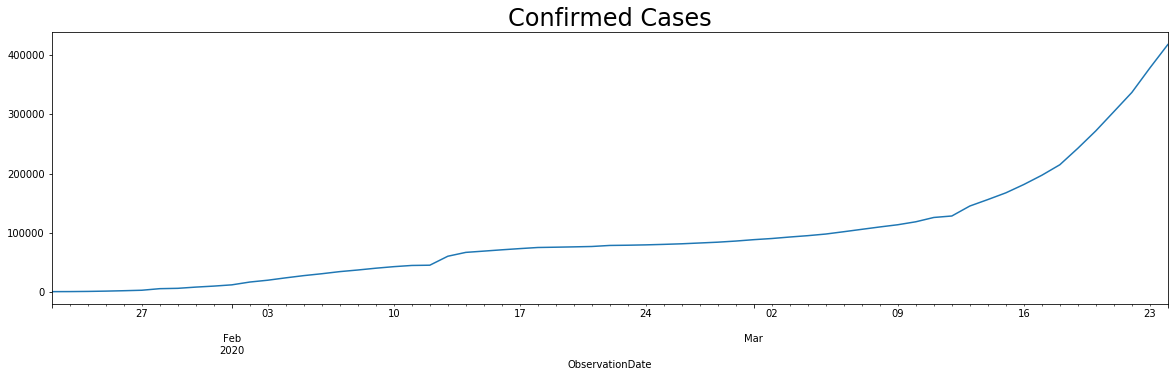

In [9]:
bydate.Confirmed.plot(figsize = (20,5))
plt.title("Confirmed Cases", size= 24)
plt.show()

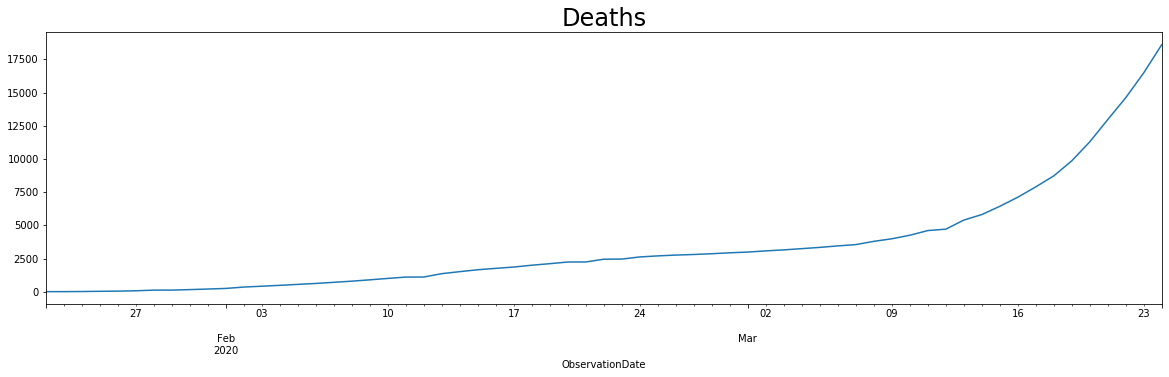

In [10]:
bydate.Deaths.plot(figsize = (20,5))
plt.title("Deaths", size= 24)
plt.show()

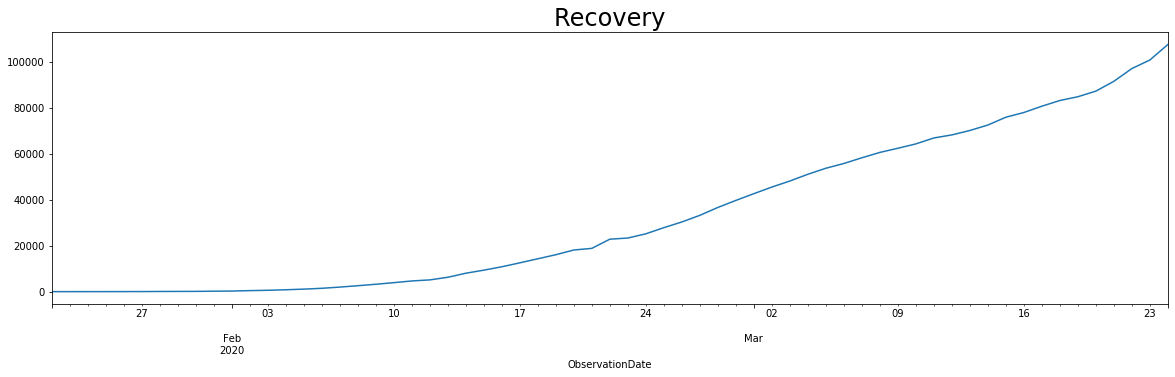

In [11]:
bydate.Recovered.plot(figsize = (20,5))
plt.title("Recovery", size= 24)
plt.show()

#### Models 

##### Train_test_split

In [13]:
size = int(len(bydate)*0.8)

In [14]:
df_train, df_test = bydate.iloc[:size], bydate.iloc[size:]

In [22]:
y_pred = df_test.copy()

In [15]:
log_series=np.log(df_train["Confirmed"])

In [ ]:
log_deaths = np.log(df_train["Deaths"])

In [ ]:
df_train

##### Dickey-fuller test 

In [16]:
sts.adfuller(df_train.Confirmed)

(0.5121314298729323,
 0.9852371943124696,
 1,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 706.3376933328723)

In [17]:
sts.adfuller(log_series)

(-9.595349512798009,
 1.9851767635488026e-16,
 0,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 -127.31164931014973)

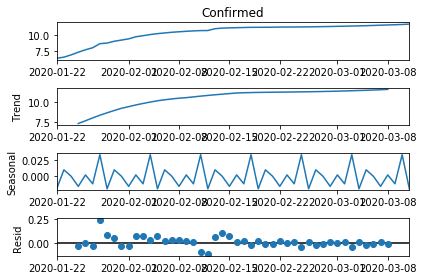

In [20]:
sm.tsa.seasonal_decompose(log_series).plot()
plt.show()

##### AR model

In [23]:
model_ar=ARIMA(log_series,(5,1,0))
model_ar_fit=model_ar.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [24]:
prediction_ar= model_ar_fit.forecast(len(df_test))[0]
y_pred["AR Model Prediction"]=list(np.exp(prediction_ar))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

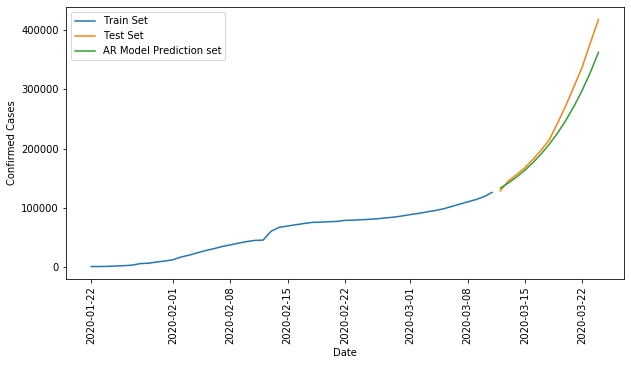

In [76]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

##### MA model

In [29]:
model_ma=ARIMA(log_series,(0,1,5))
model_ma_fit=model_ma.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [30]:
prediction_ma= model_ma_fit.forecast(len(df_test))[0]
y_pred["MA Model Prediction"]=list(np.exp(prediction_ma))

(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

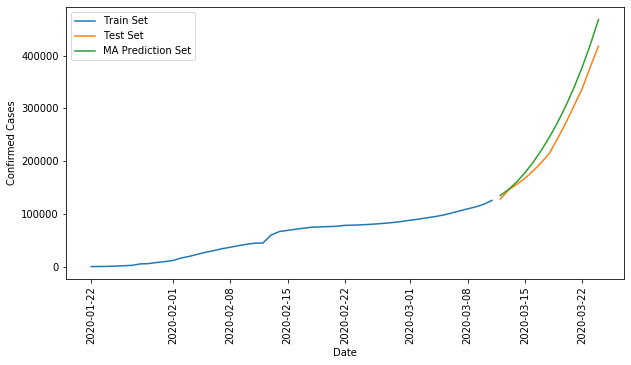

In [75]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["MA Model Prediction"],label="MA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

##### ARIMA Model

In [69]:
model_arima=ARIMA(log_series,(1,1,2))
model_arima_fit=model_arima.fit()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [70]:
prediction_arima=model_arima_fit.forecast(len(df_test))[0]
y_pred["ARIMA Model Prediction"]=list(np.exp(prediction_arima))

In [71]:
y_pred

,Confirmed,Recovered,Deaths,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
ObservationDate,,,,,,
2020-03-12,128343.0,68324.0,4720.0,133018.485724,135019.851963,133094.331836
2020-03-13,145193.0,70251.0,5404.0,141862.088082,146515.902416,141787.362645
2020-03-14,156099.0,72624.0,5819.0,151931.018194,160663.445307,151746.127830
2020-03-15,167447.0,76034.0,6440.0,163230.286686,177771.284662,163101.205559
2020-03-16,181546.0,78088.0,7126.0,176207.774386,197790.462104,176004.463323
2020-03-17,197168.0,80840.0,7905.0,190845.839912,220292.931731,190631.246337
2020-03-18,214915.0,83313.0,8733.0,207397.080902,245355.490120,207182.990417
2020-03-19,242713.0,84962.0,9867.0,226118.058942,273269.396612,225890.290384
2020-03-20,272167.0,87403.0,11299.0,247231.783832,304359.046900,247016.465421


(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]), <a list of 9 Text xticklabel objects>)

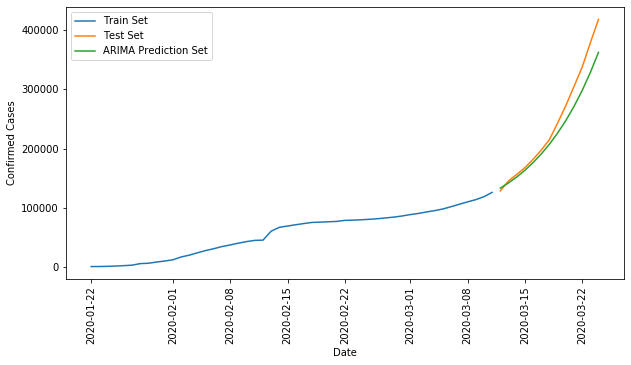

In [78]:
plt.figure(figsize=(10,5))
plt.plot(df_train.index,df_train["Confirmed"],label="Train Set")
plt.plot(df_test.index,df_test["Confirmed"],label="Test Set")
plt.plot(y_pred["ARIMA Model Prediction"],label="ARIMA Prediction Set")
plt.legend()
plt.xlabel("Date")
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)

#### Final model

In [79]:
y_pred

,Confirmed,Recovered,Deaths,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
ObservationDate,,,,,,
2020-03-12,128343.0,68324.0,4720.0,133018.485724,135019.851963,133094.331836
2020-03-13,145193.0,70251.0,5404.0,141862.088082,146515.902416,141787.362645
2020-03-14,156099.0,72624.0,5819.0,151931.018194,160663.445307,151746.127830
2020-03-15,167447.0,76034.0,6440.0,163230.286686,177771.284662,163101.205559
2020-03-16,181546.0,78088.0,7126.0,176207.774386,197790.462104,176004.463323
2020-03-17,197168.0,80840.0,7905.0,190845.839912,220292.931731,190631.246337
2020-03-18,214915.0,83313.0,8733.0,207397.080902,245355.490120,207182.990417
2020-03-19,242713.0,84962.0,9867.0,226118.058942,273269.396612,225890.290384
2020-03-20,272167.0,87403.0,11299.0,247231.783832,304359.046900,247016.465421
